# **Uplift Modeling**

*by Milara*

*September 2021*

**Introduction:**
+ One of the main applications of the Machine Learning models is to improve the **Targeted Marketing**. The Targeted Marketing is used to select the customers that most likely buy a product.
+ There are different approaches for Targeted Marketing such as the **Classical modeling** (also known as Response model). This approach is focused in training a model with customers that were sent a promotion/offer. The model separates the customers that will buy from the ones that will not buy if targeted. **This approach generates higher profit than random selection targeting.**
+ Nonetheless, the Classical modeling has a flaw. It does not separate customers that will buy even if not targeted from the ones that will only buy if targeted. In other words, the model wastes money by targeting customers that do not need it. The current solution to that issue is the Uplift modeling.
+ The **Uplift modeling** can separate customers that will buy if not targeted from the ones that will buy only if targeted, as well as avoiding customers that will not buy even if targeted. **Specifically, the model identifies the customers that are worth spending money on Targeted Marketing.**
+ This approach can also be related to the **Churn problem**, in which the goal is to avoid losing customers. It is related because it requires to send an offer to persuade the customer that the product still provide value. Therefore, it is important to send an offer to the customers that are more likely to stay if targeted.
+ **This notebook elaborates these two approaches for Targeted Marketing using a dataset with 13 million instances provided by Criteo (French advertising company)**.


**Objectives**
+ To show the Classical and Uplift modeling in Targeted Marketing

**Content**
+ [Problem understanding](#Problem-understanding)
+ [Data understanding](#Data-understanding)
    + [Basic EDA](#Basic-EDA)
    + [Imbalance](#Imbalance)
    + [Results of the treatments](#Results-of-the-treatments)
    + [Data preparation](#Data-preparation)
+ [Classical modeling](#Classical-Modeling)
    + [CM: Data preparation](#CM:-Data-preparation)
    + [CM: Data split](#CM:-Data-split)
    + [CM: Resampling](#CM:-Resampling)
    + [CM: Modeling](#CM:-Modeling)
    + [CM: Profit/Cost of the results](#CM:-Profit/Cost-of-the-results)
    + [CM: Profit/Cost curve](#CM:-Profit/Cost-curve)
    + [CM: Summary](#CM:-Summary)
+ [Uplift modeling](#Uplift-modeling)
    + [UM: Brief explanation](#UM:-Brief-explanation)
    + [UM: Data split](#UM:-Data-split)
    + [UM: Resampling](#UM:-Resampling)
    + [UM: Modeling](#UM:-Modeling)
    + [UM: Cumulative uplift curve](#UM:-Cumulative-uplift-curve)
    + [UM: Summary](#UM:-Summary)
+ [Conclusion](#Conclusion_)
+ [To try](#To-try)
+ [References](#References)


## **Problem understanding**

+ The data was obtained from Kaggle **"Uplift Modeling, Marketing and Campaing Data" provided by AI lab of Criteo** (French advertising company that provides online display adverstisements). **The data contains 13 million instances from a randomized control trial collected in two weeks**, where 84.6% of the users where sent the treatment **[1]**.
+ Each instance has 12 features that were anonymized plus a treatment variable and two target variables (visits and conversion). There is another extra variable called "exposure" which indicates whether the user was effectively exposed to the treatment.
+ For this Hackathon the notebook is just focussing on the **Conversion** column, which indicates the final user turnout which bought a particular product..
+  The models used are Logistic Regression, XGBoost and GradientBoosting Classifier.

## **Data understanding**

In [1]:
import gzip
!gunzip /content/criteo-uplift-v2.1.csv.gz

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Read the dataset
df = pd.read_csv("/content/criteo-uplift-v2.1.csv")

### **Basic EDA**

In [3]:
#Show the columns
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

There are 12 features and 4 variables with information about the treatments and targets

In [4]:
#Check for null values
df.isnull().sum()

,0
f0,0
f1,0
f2,0
f3,0
f4,0
f5,0
f6,0
f7,0
f8,0
f9,0


There are no null values

#### **Uni-variate analysis**

In [ ]:
#Quick stats of the variables
df.describe()

The variables have 13M instances each. The stats values of the features seems to be similar. To have a better picture a boxplot is shown below.

<Axes: >

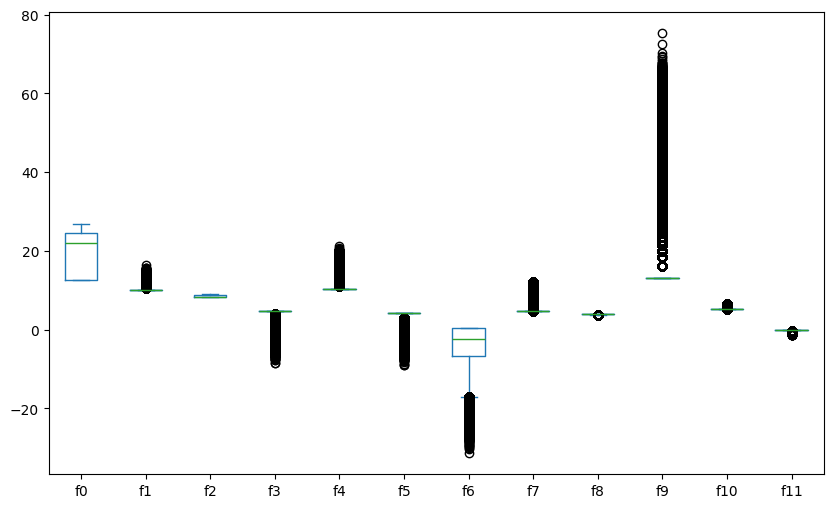

In [ ]:
#Boxplots of the features
df.drop(['treatment','conversion','visit','exposure'], axis = 1).plot.box(figsize=(10,6))

The plot shows the following:
+ The range of the features is different.
+ Only features f0 and f2 have no outliers.
+ The features that have the largest outliers are f6 and f9.
+ The features with large outliers have them only on one side of the distribution.
+ Some features such as f3, f4 and f5 seem to have a positive skeweness, while f0, f1, f4, f7 and f9 seem to have negative skewness.

#### **Multi-variate analysis**

<Axes: title={'center': 'Pearson Correlation Matrix'}>

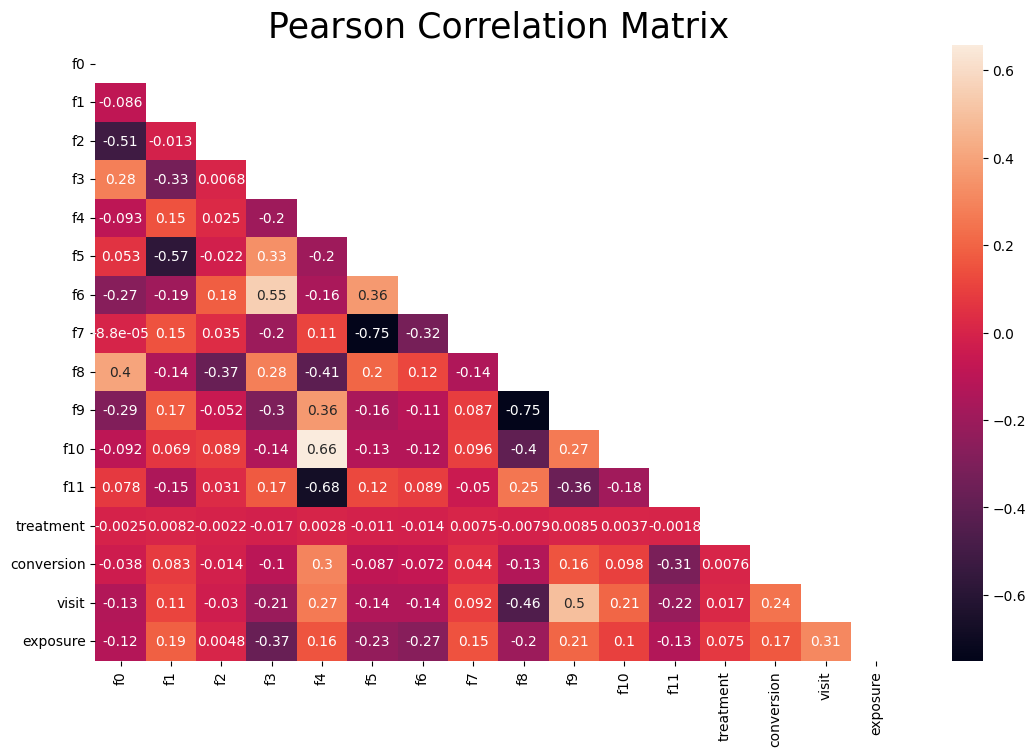

In [ ]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, mask = mask)

There are some variables with strong correlation that should be addressed to avoid repetition of information.

**In summary:**
+ There are 12 features and 2 variables for treatment and 2 variables for target
+ There are no null values in the 13M users
+ The features have outliers, positive and negative skweness and different range of values
+ Some of the features have a strong correlation between them
    + There were no features with an absolute score correlation above 0.31 for conversion
    + There were two feautures with an absolute score correlation above 0.31 for visit



### **Imbalance**

The data is highly imbalanced in four features: treatment, exposure, visits and conversion.

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64


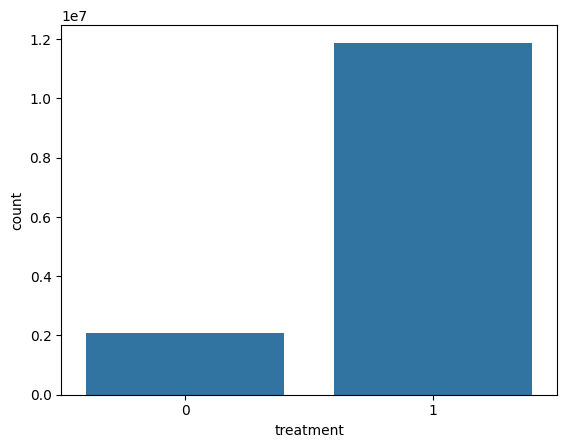

In [ ]:
#Show the proportion of treatment
sns.countplot(x='treatment', data=df)
print(df['treatment'].value_counts(normalize = True))

exposure
0    0.969369
1    0.030631
Name: proportion, dtype: float64


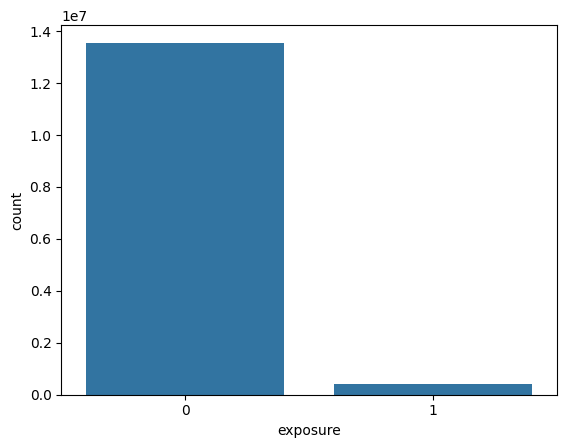

In [ ]:
#Proportion of full exposure to the treatment
sns.countplot(x='exposure', data=df)
print(df['exposure'].value_counts(normalize = True))

conversion
0    0.997083
1    0.002917
Name: proportion, dtype: float64


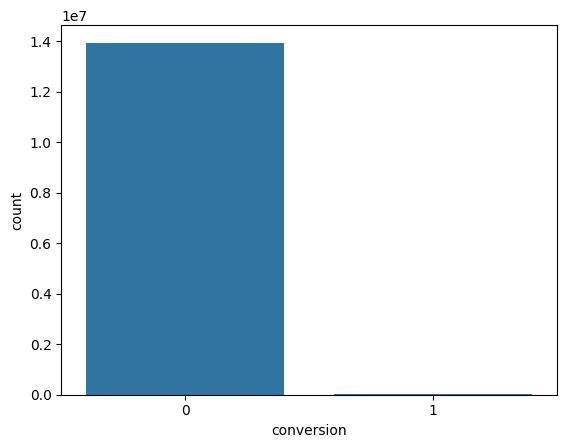

In [ ]:
#Proportion of conversion
sns.countplot(x='conversion', data=df)
print(df['conversion'].value_counts(normalize = True))

visit
0    0.953008
1    0.046992
Name: proportion, dtype: float64


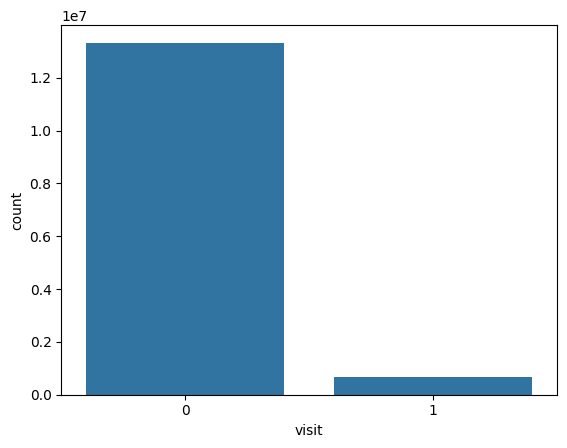

In [ ]:
#Proportion of visits
sns.countplot(x='visit', data=df)
print(df['visit'].value_counts(normalize = True))

The summary of the rounded percentages is:
+ The percetanges of **treatment** are: 85% with treatment and 15% without treatment
+ The percetanges of **exposure** are: 3% with exposure and 97% without exposure
+ The percentages of **conversion** are: 0.2% with conversion and 99% without conversion
+ The percentages of **visits** are: 5% with conversion and 95% without conversion


### **Results of the treatments**

Before moving on to the modeling stage it is highly important to determine if the randomized control trial provided a positive impact to the company. If the results generated a positive impact, then the modeling stage can be done but if the results were negative then there is no point of moving to the modeling stage. Thereby, the following analysis is intended to show the impact of the treatments on the conversions and visits. **In other words, to check if the treatment was useful or not.**

#### **Conversions**
As the goal is the conversion of the users, then how the conversion is related to the treatment and exposure?

In [5]:
#Given the treatment and exposure how is the conversion?
table_conv = df.groupby(['treatment','exposure']).agg({'conversion':['mean','sum','count']})
print(table_conv)

                   conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212


From the table of above, it can be seen the following:
+ The percentage of users who were not given the treatment (nor fully exposed) and converted is 0.19%.
+ The percentage of users who were given the treatment but were not fully exposed and converted is 0.12%
+ The percentage of users who were given the treatment and fully exposed and converted is 5.38%
**It seems that it is only worth giving the full exposure instead of giving it partially.**

#### **Visits**

If the visits were the goal, how are they related to the treatment and exposure?

In [6]:
#Given the treatment and exposure, how is the visits?
table_vis = df.groupby(['treatment','exposure']).agg({'visit':['mean','sum','count']})
print(table_vis)

                       visit                  
                        mean     sum     count
treatment exposure                            
0         0         0.038201   80105   2096937
1         0         0.034861  399314  11454443
          1         0.414538  177510    428212


The table above shows following:
+ The percentage of users who were not given the treatment (nor exposed) and visited is 3.82%
+ The percentage of users who were given the treatment but not fully exposed and visited is 3.49%
+ The percentage of users who were given the full treatment and visited is 41.45%

**It can be seen similar behavior as in conversion, it seems that only giving the full treatment and avoiding sending the partial treatment yield better results.**

#### **How do the treatment, exposure and visit impact the conversion?**

In [7]:
#Given the treatment, exposure and visits, how is the conversion?
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

From the table of above, it can be seen the following:
+ There is no conversion if the users do not visit
+ The percentage of users who were not given the treatment (nor fully exposed) and visited and converted is 5.07%.
+ The percentage of users who were given the treatment but were not fully exposed and visited and converted is 3.42%
+ The percentage of users who were given the treatment, fully exposed and visited and converted is 12.97%

**It seems that even if the users receive the partial treatment and visit there is a drop in the percetage of conversion**

In brief, there is a negative impact of the partial treatment on the results, either on visits and coversions. Furthermore, it seems that not even making the users visit with the partial treatment can yield higher conversion.

### **Statistical tests for the treatments on results**


#### *Test between control and treatment group on conversion*

In [8]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=table_conv.reset_index()[('conversion')]['count'].loc[:1])[1]

np.float64(6.983951422749621e-165)

#### *Test between control and exposure group on conversion*

In [9]:
#Get the two groups of data
proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].drop(1),
                  nobs=table_conv.reset_index()[('conversion')]['count'].drop(1))[1]

np.float64(0.0)

#### *Test between control and treatment group on visit*

In [10]:
table_conv

conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212

In [11]:
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].loc[:1],
                  nobs=table_vis.reset_index()[('visit')]['count'].loc[:1])[1]

np.float64(5.150161571101964e-128)

#### *Test between control and exposure group on visit*

In [12]:
#Get the two groups of data
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].drop(1),
                  nobs=table_vis.reset_index()[('visit')]['count'].drop(1))[1]

np.float64(0.0)

In summary:
+ If a p-value smaller than 0.05 is considered for the statistical significance, then for all test results there is enough evidence that there is an statistical difference between the proportions.
+ This is good and bad:
    + It is good because the treatment fully exposed (*exposure*) has a positive impact on conversions and visits.
    + It is bad because the treatment not fully exposed has a negative impact on conversions and visits.
    
+ This should be addressed by the company. Nevertheless, as scope of this notebooks stated, the analysis continues only for the conversion.

+ **As well, the two treatments (treatment and exposed) can be considered different given their characteristic (partially and fully completed), thus this notebook continues only analyzing the data of the exposed users as a treatment to increase the conversion. From now on the exposure feature will be called treatment.**

### **Data preparation: data cleansing to have users only exposed and not exposed.**

Given the analysis of the previous section, it is necessary to select only the data useful for the modeling

In [13]:
users_to_remove = df[(df['treatment'] == 1 ) & (df['exposure']==0)]
df_ml = df.drop(users_to_remove.index).reset_index().drop(['index','treatment', 'visit'], axis = 1)

In [ ]:
#Number of Treated but not exposed
len(users_to_remove)

11454443

exposure
0    2096937
1     428212
Name: count, dtype: int64
Normalized:
exposure
0    0.830421
1    0.169579
Name: proportion, dtype: float64


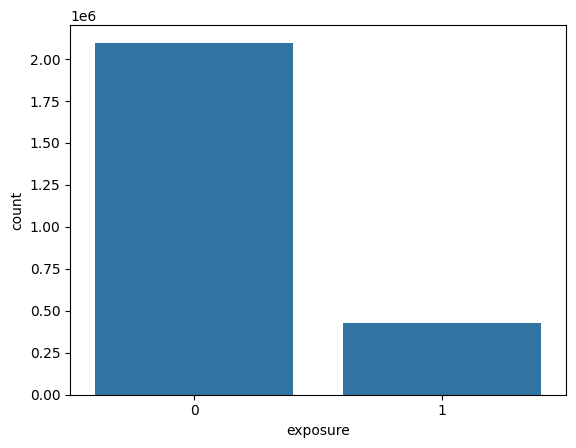

In [ ]:
#Proportion of Exposure
sns.countplot(x='exposure', data=df_ml)
print(df_ml['exposure'].value_counts())
print("Normalized:")
print(df_ml['exposure'].value_counts(normalize = True))

Users converted given no exposure
conversion
0    2092874
1       4063
Name: count, dtype: int64
Users converted given exposure
conversion
0    405181
1     23031
Name: count, dtype: int64


Text(0.5, 1.0, 'Conversion given exposure')

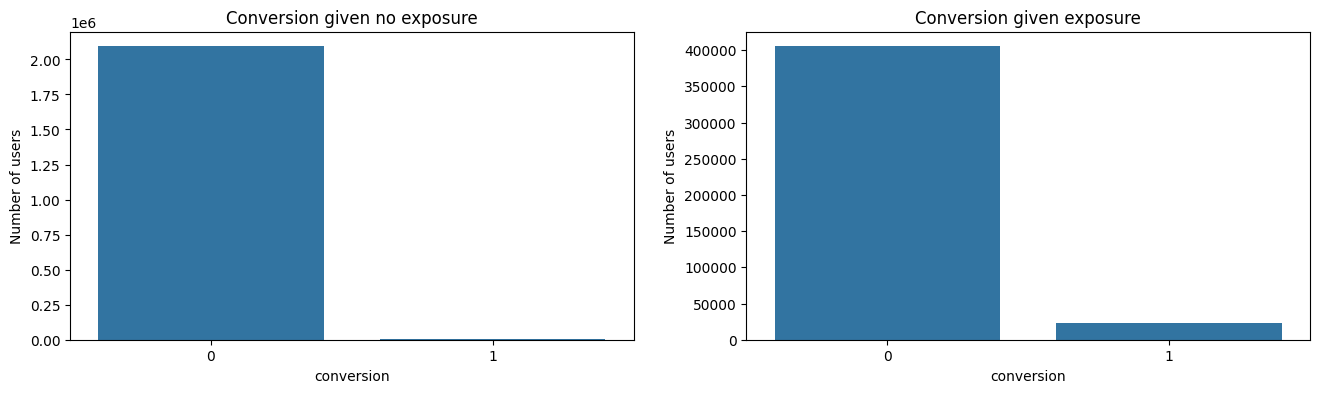

In [ ]:
df_noexp = df_ml[df_ml['exposure'] == 0]
df_exp = df_ml[df_ml['exposure'] == 1]

print("Users converted given no exposure")
print(df_noexp['conversion'].value_counts())

print("Users converted given exposure")
print(df_exp['conversion'].value_counts())

#Plot both graphs
fig, ax = plt.subplots( ncols=2, figsize = (16,4))

sns.countplot(x='conversion', data=df_noexp, ax=ax[0])
ax[0].set_ylabel('Number of users')
ax[0].set_title('Conversion given no exposure')

sns.countplot(x='conversion', data=df_exp, ax=ax[1])
ax[1].set_ylabel('Number of users')
ax[1].set_title('Conversion given exposure')

*From now on Exposure is the same as Treatment.*

#### **Data scaling**

This step is performed to make all the variables have the mean of zero and standard deviation of 1. Some models from sklearn require it because their computations are very sensitive to the range of data points. Specifically the models that work with gradient descent. Both models used in this notebook use gradient descent.

In [14]:
from sklearn import preprocessing

scaled = preprocessing.scale(df_ml.drop(['conversion','exposure'], axis = 1).values)
df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']

#### **Data split**

The following step is peformed to let a portion of the data be untouched, it will be used if necessary.

In [30]:
df_test=df_ml.drop('exposure',axis=1)
df_test

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,conversion
0,12.896938,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0
1,16.689925,10.059654,8.214383,1.267425,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,0
2,12.781566,10.059654,8.215920,1.114982,11.561050,4.115453,-7.011752,4.833815,3.799079,45.054671,5.303177,-0.337358,1
3,13.018571,10.059654,8.301697,-0.413110,10.280525,4.115453,-10.143546,4.833815,3.876391,30.796373,5.300375,-0.168679,0
4,12.704505,10.059654,8.214383,0.604065,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525144,12.758082,10.059654,8.454566,-1.450558,10.280525,3.013064,-18.209415,9.021503,3.878372,25.954644,5.300375,-0.168679,0
2525145,13.728129,10.059654,8.390505,-2.732200,10.280525,3.013064,-15.654324,11.858046,3.768021,42.253917,5.300375,-0.168679,0
2525146,18.115548,10.679513,8.544236,-2.369353,10.280525,2.230907,-17.796268,8.757396,3.808066,35.431533,5.300375,-0.168679,0
2525147,14.184428,10.059654,8.495848,2.293959,10.280525,4.115453,-4.595460,4.833815,3.872698,16.226044,5.300375,-0.168679,0


In [15]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([df_exposure, df_conversion], axis=1)

#Setting up testing and traning sets
X_train, X_test, trmnt_train , trmnt_test, y_train, y_test = train_test_split(df_sca,
                                                                             df_exposure,
                                                                             df_conversion,
                                                                             stratify = stratify_cols,
                                                                             test_size = 0.1,
                                                                             random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (2272634, 12)
Test shape: (252515, 12)


<a id='section'></a>

In [ ]:
X_train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
1513940,-0.527982,-0.154119,-0.804786,0.084223,-0.213038,0.264136,-0.863380,-0.290197,0.752865,-0.484372,-0.243674,0.138856
438603,0.674543,-0.154119,-0.804786,0.496826,-0.213038,0.264136,-0.388991,-0.290197,0.752865,-0.484372,-0.243674,0.138856
1799258,-1.186559,-0.154119,-0.068633,-2.258897,-0.213038,0.264136,-3.054741,-0.290197,0.174024,-0.126170,-0.243674,0.138856
681295,0.009053,-0.154119,-0.804786,-2.355885,-0.213038,0.264136,-1.008323,-0.290197,0.752865,-0.484372,-0.243674,0.138856
434031,0.749429,-0.154119,-0.804786,0.496826,-0.213038,0.264136,0.723666,-0.290197,0.752865,-0.484372,-0.243674,0.138856
...,...,...,...,...,...,...,...,...,...,...,...,...
54021,0.517258,-0.154119,1.313447,0.496826,-0.213038,0.264136,-0.388991,-0.290197,-0.038532,-0.484372,-0.243674,0.138856
2081637,-1.205656,-0.154119,1.615508,0.496826,-0.213038,0.264136,1.016531,-0.290197,-0.379028,-0.484372,-0.243674,0.138856
1203394,1.177707,-0.154119,-0.804786,0.496826,-0.213038,0.264136,-0.889648,-0.290197,0.752865,-0.484372,-0.243674,0.138856
1817313,-1.128767,-0.154119,0.174666,-3.149777,-0.213038,0.264136,-2.265070,-0.290197,-0.936453,1.878061,-0.243674,0.138856


In [ ]:
y_train

,conversion
1513940,0
438603,0
1799258,0
681295,0
434031,0
...,...
54021,0
2081637,0
1203394,0
1817313,0


## **Classical Modeling**

In this section the profile of the users is used to create a model that can identify new users with high probabilty of conversion if targeted. This is called the classical modeling because it uses data labeled with the ground truth. The benefit of this type of modeling is that it helps you to avoid the users who will not convert if targeted. **Thus, the data to use is only the group of users who were targeted ("exposed").** This approach is also called Response model and Traditional Propensity model **[2,10]**.

### **CM: Data preparation**

The instances that were given the treatment are selected.

In [18]:
#Selection of instances only exposed
y_traincml = y_train[trmnt_train==1]
X_traincml = X_train[trmnt_train==1]

Even that a vast number of instaces were removed the imbalancing remains. Note that from having 13M instances only around 400k have the characteristics needed for this stage.

conversion
0    364663
1     20728
Name: count, dtype: int64
Normalized:
conversion
0    0.946216
1    0.053784
Name: proportion, dtype: float64


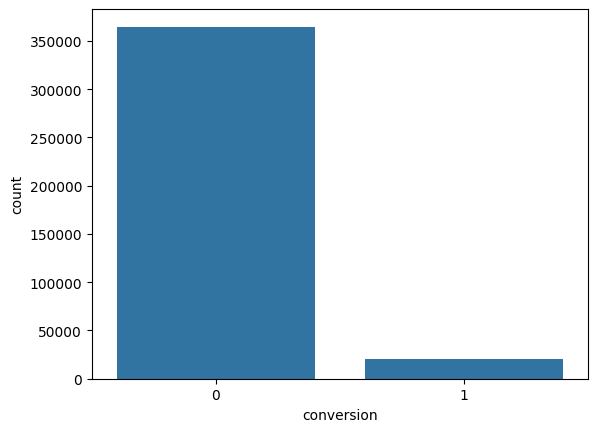

In [19]:
#Imbalanced in the conversion variable
sns.countplot(x='conversion', data=y_traincml.to_frame())
print(y_traincml.value_counts())
print("Normalized:")
print(y_traincml.value_counts(normalize = True))

### **CM: Data split**

The data is divided in train and validation tests.

In [20]:
#Setting up testing and training sets
X_train_cml, X_val_cml, y_train_cml, y_val_cml = train_test_split(X_traincml,y_traincml, test_size=0.3, random_state=42)

print('Train instances: {}, None_Conversion: {} and Conversion: {}'.format(len(y_train_cml),
                                                                         y_train_cml.value_counts()[0],
                                                                         y_train_cml.value_counts()[1]))

print('Val instances: {}, None_Conversion: {} and Conversion: {}'.format( len(y_val_cml),
                                                                         y_val_cml.value_counts()[0],
                                                                         y_val_cml.value_counts()[1]))

Train instances: 269773, None_Conversion: 255282 and Conversion: 14491
Val instances: 115618, None_Conversion: 109381 and Conversion: 6237


### **CM: Resampling**

The proportion of the target variable is imbalanced, thus the over-sampling technique SMOTE is used to increase the number of conversion users to have half of the size of the non_conversion. Note that other ratio could be used.

In [21]:
#SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42 )
X_train_sm, y_train_sm = sm.fit_resample(X_train_cml, y_train_cml)

print(y_train_sm.value_counts())

conversion
0    255282
1    255282
Name: count, dtype: int64


### **CM: Modeling**

Three models are used, the first model is random (to have a baseline), the second is Logistic Regression and the third is XGBoost. As the target variable is imbalanced all the models are evaluated on precision and recall to focus on False Positives and False Negatives. An important note is that all of the the models are trained on balanced data to learn how to generalize and then evaluated on imbalanced  data.

In [25]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [26]:
#Logistic regression model
logreg_sm = LogisticRegression().fit(X_train_sm.values, y_train_sm.values)
logreg_sm_pred = logreg_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, logreg_sm_pred))
print("Recall: ", recall_score(y_val_cml, logreg_sm_pred))
print(classification_report(y_val_cml, logreg_sm_pred))

Precision:  0.19509761388286334
Recall:  0.721019721019721
              precision    recall  f1-score   support

           0       0.98      0.83      0.90    109381
           1       0.20      0.72      0.31      6237

    accuracy                           0.82    115618
   macro avg       0.59      0.78      0.60    115618
weighted avg       0.94      0.82      0.87    115618



In [27]:
#Extreme Gradient Boosting
xgb_sm = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr',  use_label_encoder = False).fit(X_train_sm.values,
                                                                                      y_train_sm.values)
xgb_sm_pred = xgb_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, xgb_sm_pred))
print("Recall: ", recall_score(y_val_cml, xgb_sm_pred))

print(classification_report(y_val_cml, xgb_sm_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:27:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Precision:  0.25145579671784013
Recall:  0.5331088664421998
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    109381
           1       0.25      0.53      0.34      6237

    accuracy                           0.89    115618
   macro avg       0.61      0.72      0.64    115618
weighted avg       0.93      0.89      0.91    115618



In [84]:
!pip install imbalance-xgboost

In [88]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import GridSearchCV
xgboster = imb_xgb(special_objective='focal',focal_gamma=0.3)
xgboster.fit(np.asarray(X_train_sm),np.asarray(y_train_sm))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


In [90]:
pred=xgboster.predict_determine(np.asarray(X_val_cml))
print(classification_report(y_val_cml, pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92    109381
           1       0.21      0.65      0.32      6237

    accuracy                           0.85    115618
   macro avg       0.60      0.76      0.62    115618
weighted avg       0.94      0.85      0.89    115618



In [44]:
X_trainexplainer = LimeTabularExplainer(
    training_data=X_train_sm.values,           # use .values to pass NumPy array
    feature_names=X_train_sm.columns,
    class_names=['Conversion'],
    mode='classification'
)

In [53]:
i = 222  # any index of test sample
exp = X_trainexplainer.explain_instance(X_val_cml.values[i],logreg_sm.predict_proba,num_features=12)

exp.show_in_notebook(show_table=True)  # or use exp.as_list() for printing


In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
clf = GradientBoostingClassifier(max_depth=3, random_state=0).fit(X_train_sm, y_train_sm)


In [72]:
preds=clf.predict(X_val_cml)
print(classification_report(y_val_cml, preds))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91    109381
           1       0.22      0.69      0.33      6237

    accuracy                           0.85    115618
   macro avg       0.60      0.77      0.62    115618
weighted avg       0.94      0.85      0.88    115618



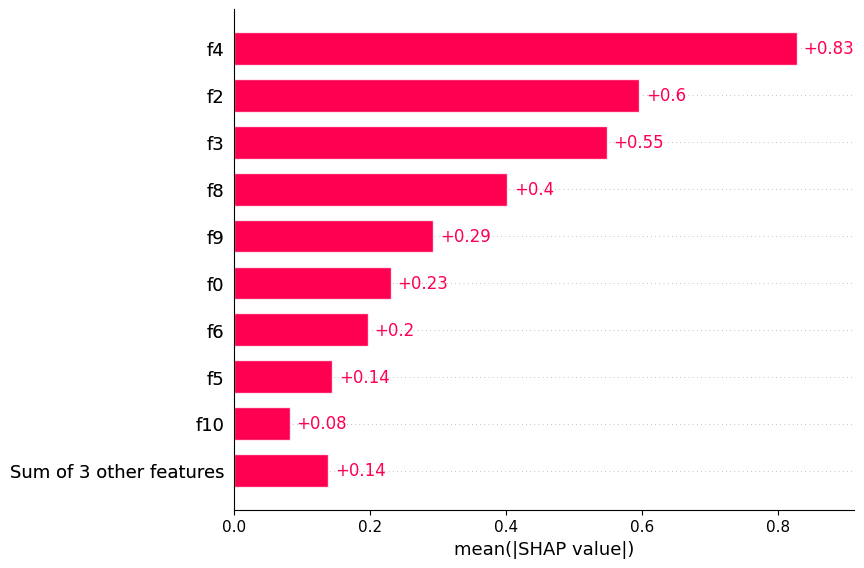

In [59]:
import shap

explainer = shap.Explainer(xgb_sm)
shap_values = explainer(X_val_cml)

shap.plots.bar(shap_values)

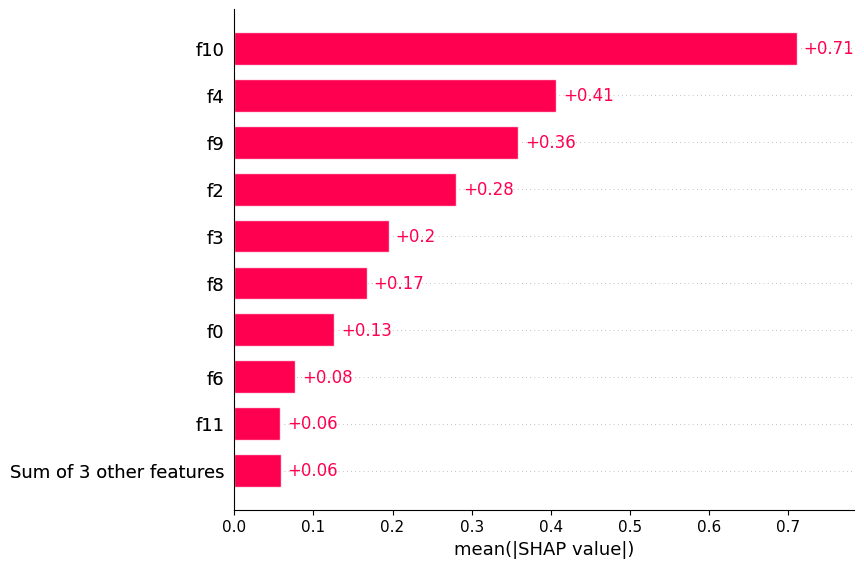

In [63]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_val_cml)

shap.plots.bar(shap_values)

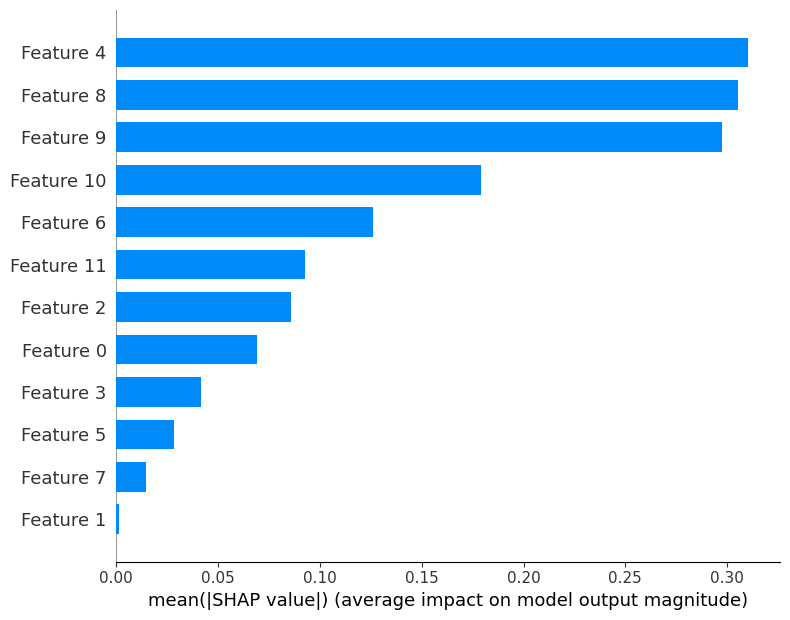

In [71]:
masker = shap.maskers.Independent(data = X_val_cml)
explainer = shap.LinearExplainer(logreg_sm,masker=masker)
shap_values = explainer.shap_values(X_val_cml)

shap.summary_plot(shap_values,plot_type='bar')

## **Uplift modeling**

This technique combines Machine Learning with causal inference to determine the impact of the treatment (or an action) on the target variable. In other words, it helps to know if its necessary to treat the user or not. To be clearer, the method is explained with the following table **[4]**:


|                    | Not buy if not treated | Buy if not treated |
|--------------------|------------------------|--------------------|
| **Buy if treated**     | Persuadables           | Sure things        |
|**Not buy if treated** | Lost Causes            | Sleeping dogs      |



### **UM: Data split**

The data is split in two train and test, but it also is necessary to split the treatment variable.

In [73]:
stratify_cols = pd.concat([trmnt_train, y_train], axis=1)

#Setting up testing and traning sets
X_trainup, X_valup, trmnt_trainup , trmnt_valup , y_trainup , y_valup = train_test_split(X_train,
                                                                                         trmnt_train,
                                                                                         y_train,
                                                                                         stratify = stratify_cols,
                                                                                         test_size = 0.3,
                                                                                         random_state=42)

print(f"Train shape: {X_trainup.shape}")
print(f"Validation shape: {X_valup.shape}")

Train shape: (1590843, 12)
Validation shape: (681791, 12)


<Axes: xlabel='exposure', ylabel='count'>

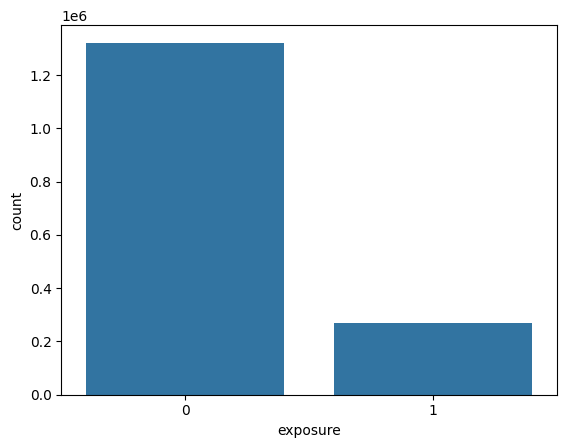

In [74]:
#Imbalanced in the treatment variableo
sns.countplot(x='exposure', data=trmnt_trainup.to_frame())

This could be also be done with over-sampling the minority class, but as the instances are over a million, it requires more comptuer resources and time to make the computations.

In [75]:
#Subsampling the mayority class (could be done with over-sampling the minority class but it consumes too much resources)
tmp = X_trainup.copy()
tmp.insert(len(tmp.columns)-1, 'conversion', y_trainup.values)
tmp.insert(len(tmp.columns)-1, 'exposure', trmnt_trainup.values)

#separte df based on the treatment
tmp1 = tmp[tmp['exposure']==1]
tmp2 = tmp[tmp['exposure']==0]

#Subsampling
tmp2 = tmp2.sample(n=len(tmp1))
tmp3 = pd.concat([tmp1,tmp2], axis=0)

#Updating the variables
X_trainup_sub = tmp3.drop(['exposure','conversion'], axis = 1)
trmnt_trainup_sub = tmp3['exposure']
y_trainup_sub = tmp3['conversion']

Plot the balance treatment feature

<Axes: xlabel='exposure', ylabel='count'>

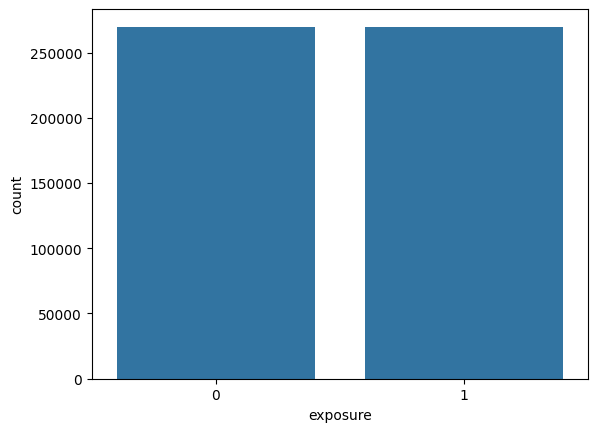

In [76]:
#Checking the umbalance
sns.countplot(x='exposure', data=trmnt_trainup_sub.to_frame())

In [77]:
!pip install scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.8 MB/s eta 0:00:00


In [78]:
from sklift.models import SoloModel, TwoModels

estimator = LogisticRegression()

#Single Model
sm = SoloModel(estimator)
sm = sm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_sm = sm.predict(X_valup)

#Two Independent models
tm = TwoModels(estimator_trmnt= LogisticRegression(), estimator_ctrl= LogisticRegression(), method='vanilla')
tm = tm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_tm = tm.predict(X_valup)

### **UM: Cumulative uplift curve**

In [79]:
def get_tc(treatment,target):
    """
    Function that returns helps to select the users that were in the control group and have a positive response

    Parameters:
    ------------
    treatment = treatment
    target = the response
    """
    if not target:
        return 0
    elif not treatment:
        return 1
    else:
        return 0

def compute_gain(df_x, uplift, treatment, y, rnd = False):
    """
    Function that computes the cumulative gains in a dataframe

    Parameters:
    ------------
    uplift = arr with the predicted uplifts by the models
    trtment = arr with the treatment indicator (test)
    y = arr target variable (test)
    rnd = bool indicating if random selection
    """
    e = 0.0000000000001 # to avoid divisions by zero
    base = pd.DataFrame({'uplift':uplift, 'treatment':treatment.values, 'target': y.values})

    df = pd.concat([df_x,base], axis = 1)

    #sort based on the flag
    if rnd:
        df = df.sample(frac=1).reset_index().drop('index', axis =1)
    else:
        df = df.sort_values(by='uplift', ascending = False).reset_index().drop('index', axis =1)

    #Compute the cumulative treatment size
    df['cum_trs'] = df['treatment'].cumsum(axis=0)

    #Compute the cumulative control size
    df['cum_crs'] = (df.index+1) - df['treatment'].cumsum(axis=0)

    #Compute target given treatment
    df['ttr'] = df['treatment'] * df['target']

    #Compute target given control
    df['tcr'] = df.apply(lambda x: get_tc(x.treatment, x.target), axis=1)

    #Compute cumulative target given treatment
    df['cum_ttr'] = df['ttr'].cumsum(axis=0)

    #Compute cumulative target given control
    df['cum_tcr'] = df['tcr'].cumsum(axis=0)

    #Compute cumulative gain from one to uplift [descent]
    df['cum_gain'] = (df['cum_ttr']/(df['cum_trs']+e)) - (df['cum_tcr']/(df['cum_crs']+e))

    #Compute cumulative gain from zero to uplift [ascending]
    df['cum_gain2'] = df['cum_gain']*(df['cum_trs']+df['cum_crs']+e)/ len(df)

    return df


In [80]:
df_x_valup = X_valup.reset_index().drop('index',axis=1)

#Compute gain for the three models
sm_gain = compute_gain(df_x_valup, uplift_sm,trmnt_valup, y_valup)
tm_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup)
rnd_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup, True)

In [81]:


save_df = pd.DataFrame({'gain_twomodel':tm_gain['cum_gain2'] , 'gain_random':rnd_gain['cum_gain2']})


The results are plotted

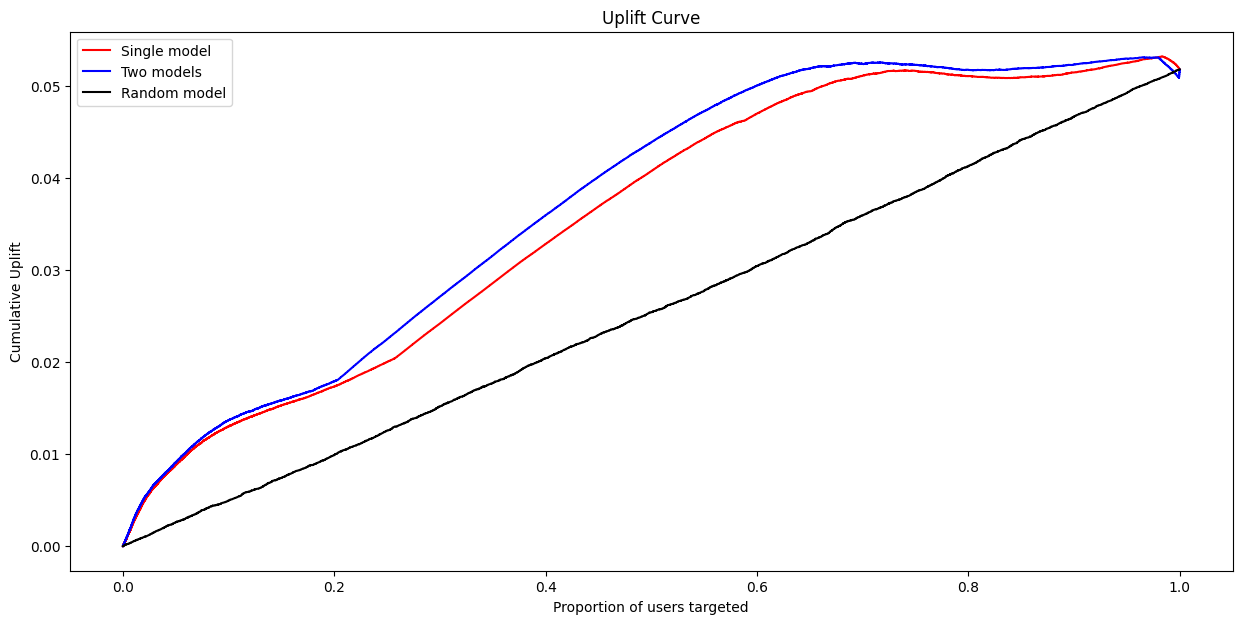

In [83]:
#Plot the results
_, axes = plt.subplots(figsize=(15, 7))

instances=np.arange(0, 1, (1/len(y_valup)))

axes.set_title("Uplift Curve")
axes.set_xlabel("Proportion of users targeted")
axes.set_ylabel("Cumulative Uplift")
axes.plot(instances, sm_gain['cum_gain2'].values, '-', color="r",label="Single model")
axes.plot(instances, tm_gain['cum_gain2'].values, '-', color="b",label="Two models")
axes.plot(instances, rnd_gain['cum_gain2'].values, '-', color="k",label="Random model")
axes.legend(loc="best")
#axes.set_xlim(0,0.5)
#axes.set_ylim(0,0.5)
plt.show()

The graph above shows the following:
+ The x axis is the proportion of data used by the company to send the targeted marketing.
+ The y axis is the uplift obtained for targeting the users.
+ **The curves show the cummulative profit of users that were sorted by their probability of being converted. In other words, the first users targeted are the ones with highest uplift.**

Regarding the models:
+ All models get eventually to the 5% of uplift after targeting all the users.
+ **The objective of the curves is to show that if only 50% of the users are targeted, then it would be wise to use the results of the Two models because it reaches almost 5% of the uplift, while the random selection would only reach around half of the maximum uplift.** The proportion of users can be changed based on the needs of the company.
+ The results of the single and two models have similar behaviour, but the two models still provide better results from 0.2 to 0.8 proportion of users.

As well the graph implies the following:
+ The first part of the curve are the users are the persudables, followed by the sure things and lost causes, and finally the sleeping dogs.
+ The ideal curve is the one that with the first amount of instances reaches the maximum uplift, then the curve keeps the same level of uplift due to the sure things and lost causes, and finally the curve will decrease at some point due to the sleeping dogs.

### **UM: Summary**

+ This section elaborates on the uplift modeling approach to identify persuadables users. The procedure followed was to scale and resample the data, generate 3 models and finally compare the models using a Cumulative uplift curve. Other techniques to improve the model results such as outlier removal, feature selection and hyperparameter tunning were not used due to scope of the analysis. The same case for the evaluation with cross-validation.
+ The results show that by using the uplift modeling the gains on the uplift can be doubled for a certain amount of targeted users.
+ **A disadvatage of this approach is that the ground truth is not know because a customer can not receive and not receive a treatment (promotion). Thus, the uplift model has no error to be compared such as Classical modeling, meaning that the outputs generated by both approached cannot be compared with the same metrics. [11]**
+ Nevertheless, there are some research articles proposing different metrics to assess both models in terms of profit and costs. But this is not in the scope of this notebook.
